In [2]:
import os
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Configurações do Artigo (Korzeniowski & Widmer, 2016)
SR = 44100            # Sample Rate [cite: 98]
FFT_SIZE = 8192       # Frame Size [cite: 98]
HOP_SIZE = 4410       # Hop Size (aprox 10 fps) [cite: 98]
FPS = SR / HOP_SIZE   # Frames por segundo (~10)
CONTEXT_W = 7         # 0.7s de contexto para cada lado (Total 15 frames) [cite: 104, 105]
BINS_OCTAVE = 24      # Quarter-tone [cite: 100]
FMIN = 30             # Frequência mínima [cite: 100]
N_BINS = 178          # Total de bins [cite: 100]
NUM_CLASSES = 12      # 12 notas cromáticas para o vetor alvo

**Funções de Processamento de Áudio e Texto**

In [6]:
def compute_log_spectrogram(audio_path):
    """
    Reproduz o pré-processamento: STFT -> Log Filterbank -> Log Compression
    """
    # 1. Carregar Áudio (Mono, 44.1kHz)
    y, sr = librosa.load(audio_path, sr=SR, mono=True)
    
    # 2. STFT
    S = np.abs(librosa.stft(y, n_fft=FFT_SIZE, hop_length=HOP_SIZE))
    
    # 3. Mapeamento Linear -> Logarítmico (Quarter-tone)
    # Criamos um filtro para mapear as frequências da FFT para a escala log desejada
    fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=FFT_SIZE)
    # Usamos a lógica de Mel filters do librosa, mas adaptada para Log-Freq
    # Nota: VQT é uma aproximação moderna válida, mas aqui tentamos simular o filtro triangular
    # Para simplificar e manter robustez local, usaremos VQT que gera bins logarítmicos diretos
    # Se quiser reprodução EXATA pixel a pixel, seria necessário construir a matriz de filtros manualmente.
    
    cqt = np.abs(librosa.vqt(y, sr=sr, hop_length=HOP_SIZE, 
                             fmin=FMIN, n_bins=N_BINS, 
                             bins_per_octave=BINS_OCTAVE))
    
    # 4. Compressão Logarítmica: log(1 + S) [cite: 101]
    S_log = np.log1p(cqt)
    
    # Transpor para formato (Tempo, Frequencia)
    return S_log.T

def parse_lab_file(path):
    """
    Lê arquivos e retorna DataFrame
    """
    df = pd.read_csv(path, sep=';', names=['start', 'end', 'shorthand'], header=None)
    return df

def get_chroma_target(chord_label):
    """
    Converte label de acorde (ex: 'A:min') para vetor binário de 12 posições.
    """
    # Mapeamento de notas
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    note_map = {n: i for i, n in enumerate(notes)}
    # Alias comuns
    alias = {'Db':'C#', 'Eb':'D#', 'Gb':'F#', 'Ab':'G#', 'Bb':'A#'}
    
    target = np.zeros(12, dtype='float32')
    
    if chord_label in ['N', 'N:N', 'silence']:
        return target
        
    # Parsing simples (ex: "A:min" ou "Bb:maj")
    try:
        if ':' in chord_label:
            root, quality = chord_label.split(':')
        else:
            root, quality = chord_label, 'maj'
            
        root = alias.get(root, root)
        if root not in note_map: return target # Ignora acordes complexos não mapeados
        
        root_idx = note_map[root]
        
        # Intervalos (Semitons)
        if 'min' in quality:
            intervals = [0, 3, 7]
        elif 'dim' in quality:
            intervals = [0, 3, 6]
        else: # Assume Maior (maj, 7, etc) - Simplificação do artigo
            intervals = [0, 4, 7]
            
        for iv in intervals:
            target[(root_idx + iv) % 12] = 1.0
            
    except:
        pass # Falha silenciosa para manter o fluxo
        
    return target

**Data Generator**

In [15]:
from tensorflow.keras.utils import Sequence
import pandas as pd
import numpy as np
import os

class SchubertDataGenerator(Sequence):
    def __init__(self, file_list, audio_dir, annot_dir, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        
        self.filenames = file_list
        self.audio_dir = audio_dir
        self.annot_dir = annot_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.data_cache = [] 
        self._preload_data()
        self.indexes = np.arange(len(self.data_cache))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _preload_data(self):
        print(f"Carregando {len(self.filenames)} arquivos...")
        
        for fname in self.filenames:
            a_path = os.path.join(self.audio_dir, fname + '.wav')
            # Ajuste aqui se seu arquivo for .lab ou .csv
            l_path = os.path.join(self.annot_dir, fname + '.csv') 
            
            if not os.path.exists(l_path):
                continue
            
            try:
                # O processamento de áudio continua igual
                spec = compute_log_spectrogram(a_path)
            except Exception as e:
                print(f"Erro audio {fname}: {e}")
                continue

            num_frames = spec.shape[0]
            
            try:
                df = pd.read_csv(l_path, sep=';') 
            except Exception as e:
                print(f"Erro CSV {fname}: {e}")
                continue

            targets = np.zeros((num_frames, 12))
            
            for _, row in df.iterrows():
                # Assumindo que: col 0 = start, col 1 = end, col 2 = shorthand
                s_time = row.iloc[0] 
                e_time = row.iloc[1]
                label = row.iloc[2] 
                
                s_frame = int(s_time * FPS)
                e_frame = int(e_time * FPS)
                
                chroma_vec = get_chroma_target(label)
                
                s = max(0, s_frame)
                e = min(num_frames, e_frame)
                targets[s:e] = chroma_vec

            # Padding e Janelamento
            spec_padded = np.pad(spec, ((CONTEXT_W, CONTEXT_W), (0, 0)), mode='constant')
            
            for i in range(num_frames):
                window = spec_padded[i : i + (2 * CONTEXT_W + 1)]
                target = targets[i]
                self.data_cache.append((window.flatten(), target))
                
    def __len__(self):
        return int(np.floor(len(self.data_cache) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = [], []
        for k in indexes:
            feat, targ = self.data_cache[k]
            X.append(feat)
            y.append(targ)
        return np.array(X), np.array(y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

**Treinamento**

In [16]:
# 1. Inicializa o Gerador

AUDIO_DIR = '../SWD/audio_wav' 
ANNOT_DIR = '../SWD/ann_audio_chord'

all_files = sorted([
    f.replace('.wav', '') 
    for f in os.listdir(AUDIO_DIR) 
    if f.endswith('.wav')
])

print(f"Total de arquivos encontrados: {len(all_files)}")

# 2. Divisão Manual (75% Treino, 10% Validação, 15% Teste)
# Teste: As últimas 4 músicas (21, 22, 23, 24)
test_files = all_files[-4:]
# Validação: As 2 anteriores ao teste (19, 20)
# Usadas apenas para monitorar o treino, a rede não aprende com elas
val_files = all_files[-6:-4]
# Treino: Todas as outras (01 até 18)
train_files = all_files[:-6]

print(f"--- Divisão ---")
print(f"Treino: {len(train_files)} músicas")
print(f"Validação: {len(val_files)} músicas")
print(f"Teste: {len(test_files)} músicas (Reservadas para o final)")

train_gen = SchubertDataGenerator(
    file_list=train_files,   
    audio_dir=AUDIO_DIR,
    annot_dir=ANNOT_DIR,
    batch_size=512,
    shuffle=True         
)

# 2. Modelo (Deep Chroma Extractor)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

model = Sequential([
    Input(shape=(2670,)), # Input Layer [cite: 116]
    Dense(512, activation='relu'), # Hidden 1 [cite: 114]
    Dropout(0.5),                  # Dropout [cite: 126]
    Dense(512, activation='relu'), # Hidden 2
    Dropout(0.5),
    Dense(512, activation='relu'), # Hidden 3
    Dropout(0.5),
    Dense(12, activation='sigmoid') # Output Layer [cite: 115]
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # [cite: 119, 124]

# 3. Treinar
history = model.fit(train_gen, epochs=50) # Use EarlyStopping se desejar

Total de arquivos encontrados: 24
--- Divisão ---
Treino: 18 músicas
Validação: 2 músicas
Teste: 4 músicas (Reservadas para o final)
Carregando 18 arquivos...
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2026 - loss: 0.4806
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2596 - loss: 0.3178
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2774 - loss: 0.2629
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2762 - loss: 0.2318
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2798 - loss: 0.2130
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2797 - loss: 0.1962
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2829 - loss: 0.1834
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2822 - loss: 0.1712
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2937 - loss: 0.1607
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2957 - los

In [22]:
import librosa
import librosa.filters
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def extract_all_features(file_list, audio_dir, annot_dir, model):
    
    data = {
        'C': [], 'C_log': [], 'S_log': [], 'Deep': [], 'y': []
    }
    
    print(f"Processando {len(file_list)} arquivos para comparação completa...")
    
    for fname in file_list:
        a_path = os.path.join(audio_dir, fname + '.wav')
        l_path = os.path.join(annot_dir, fname + '.csv')
        
        if not os.path.exists(a_path) or not os.path.exists(l_path): continue
            
        y_audio, sr = librosa.load(a_path, sr=SR)
        
        try:
            df = pd.read_csv(l_path, sep=';') 
        except: continue

        total_frames = int(len(y_audio) / HOP_SIZE) + 1
        targets = np.zeros((total_frames,), dtype=int)
        
        for _, row in df.iterrows():
            # Forçamos a conversão para float caso o pandas tenha lido como texto
            try:
                start_time = float(row.iloc[0])
                end_time = float(row.iloc[1])
                label = row.iloc[2]
            except ValueError:
                # Se der erro (ex: leu um cabeçalho 'start' como dado), pula a linha
                continue

            s_frame = int(start_time * FPS)
            e_frame = int(end_time * FPS)
            
            chroma_vec = get_chroma_target(label)
            if np.sum(chroma_vec) > 0:
                class_idx = np.argmax(chroma_vec)
            else:
                class_idx = 0 
                
            s = max(0, s_frame)
            e = min(total_frames, e_frame)
            # Proteção extra: só preenche se s < e
            if s < e:
                targets[s:e] = class_idx
            
        # Transformamos o array 1D (N,) em 2D (N, 1) para o vstack funcionar
        targets = targets.reshape(-1, 1)
        data['y'].append(targets)
        
        # --- BASELINES ---
        # 1. Standard CQT
        c_std = librosa.feature.chroma_cqt(y=y_audio, sr=sr, hop_length=HOP_SIZE)
        data['C'].append(c_std.T) 
        
        # 2. Log CQT
        CQT_complex = librosa.cqt(y=y_audio, sr=sr, hop_length=HOP_SIZE, n_bins=84)
        CQT_log = np.log1p(np.abs(CQT_complex))
        chroma_filter = librosa.filters.cq_to_chroma(CQT_complex.shape[0])
        c_log = chroma_filter.dot(CQT_log)
        data['C_log'].append(c_log.T)

        # 3. Spectrogram
        s_log_feats = compute_log_spectrogram(a_path)
        data['S_log'].append(s_log_feats)
        
        # 4. Deep Chroma
        spec_padded = np.pad(s_log_feats, ((CONTEXT_W, CONTEXT_W), (0, 0)), mode='constant')
        windows = []
        limit = min(total_frames, s_log_feats.shape[0])
        for i in range(limit):
            w = spec_padded[i : i + (2*CONTEXT_W + 1)].flatten()
            windows.append(w)
        
        if len(windows) > 0:
            deep_feats = model.predict(np.array(windows), verbose=0, batch_size=512)
            data['Deep'].append(deep_feats)
        else:
            data['Deep'].append(np.zeros((limit, 12)))

    # Empilhando tudo
    final_data = {}
    for key in data:
        if len(data[key]) > 0:
            final_data[key] = np.vstack(data[key])
            
    if 'y' in final_data:
        final_data['y'] = final_data['y'].flatten()
        
    min_len = min([len(final_data[k]) for k in final_data])
    for key in final_data:
        final_data[key] = final_data[key][:min_len]
        
    return final_data

**Regressão Logística**

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

results_data = extract_all_features(test_files, AUDIO_DIR, ANNOT_DIR, model)

# 2. Preparar Divisão para o Classificador Final
# Dividimos os dados extraídos em Treino (para calibrar a Regressão Logística) e Teste (Avaliação)
from sklearn.model_selection import train_test_split

y_all = results_data['y']
# Split 50% para treinar o classificador linear, 50% para ver o resultado
idx_train, idx_test = train_test_split(np.arange(len(y_all)), test_size=0.5, random_state=42)

y_train_lr = y_all[idx_train]
y_test_lr = y_all[idx_test]

methods = ['C', 'C_log', 'S_log', 'Deep']
accuracies = {}

print(f"\n--- RESULTADOS FINAIS (Schubert Winterreise) ---")
print(f"{'MÉTODO':<15} | {'ACURÁCIA':<10} | {'DIMENSÃO':<10}")
print("-" * 45)

for method in methods:
    X = results_data[method]
    
    # Padronização (Importante para Regressão Logística convergir)
    scaler = StandardScaler()
    X_train_lr = scaler.fit_transform(X[idx_train])
    X_test_lr = scaler.transform(X[idx_test])
    
    # Treinar Regressão Logística [cite: 129]
    clf = LogisticRegression(max_iter=1000, solver='lbfgs', C=0.1)
    clf.fit(X_train_lr, y_train_lr)
    
    # Avaliar
    y_pred = clf.predict(X_test_lr)
    acc = accuracy_score(y_test_lr, y_pred)
    accuracies[method] = acc
    
    dim = X.shape[1]
    print(f"{method:<15} | {acc:.2%}    | {dim}")

# Verificando a conclusão do artigo
winner = max(accuracies, key=accuracies.get)
print("-" * 45)
print(f"Vencedor: {winner}")

if winner == 'Deep':
    print("CONCLUSÃO: O Deep Chroma Extractor superou as baselines, reproduzindo o resultado do artigo")
elif winner == 'S_log':
    print("CONCLUSÃO: O Spectrograma venceu. Isso acontece às vezes (vide Tabela 1 do artigo para RWC dataset).")
else:
    print("CONCLUSÃO: As baselines tradicionais venceram. Pode ser necessário mais dados de treino ou ajuste de hiperparâmetros.")

Processando 4 arquivos para comparação completa...

--- RESULTADOS FINAIS (Schubert Winterreise) ---
MÉTODO          | ACURÁCIA   | DIMENSÃO  
---------------------------------------------
C               | 84.67%    | 12
C_log           | 77.26%    | 12
S_log           | 83.16%    | 178
Deep            | 87.61%    | 12
---------------------------------------------
Vencedor: Deep
CONCLUSÃO: O Deep Chroma Extractor superou as baselines, reproduzindo o resultado do artigo


**Gráfico de comparação** 

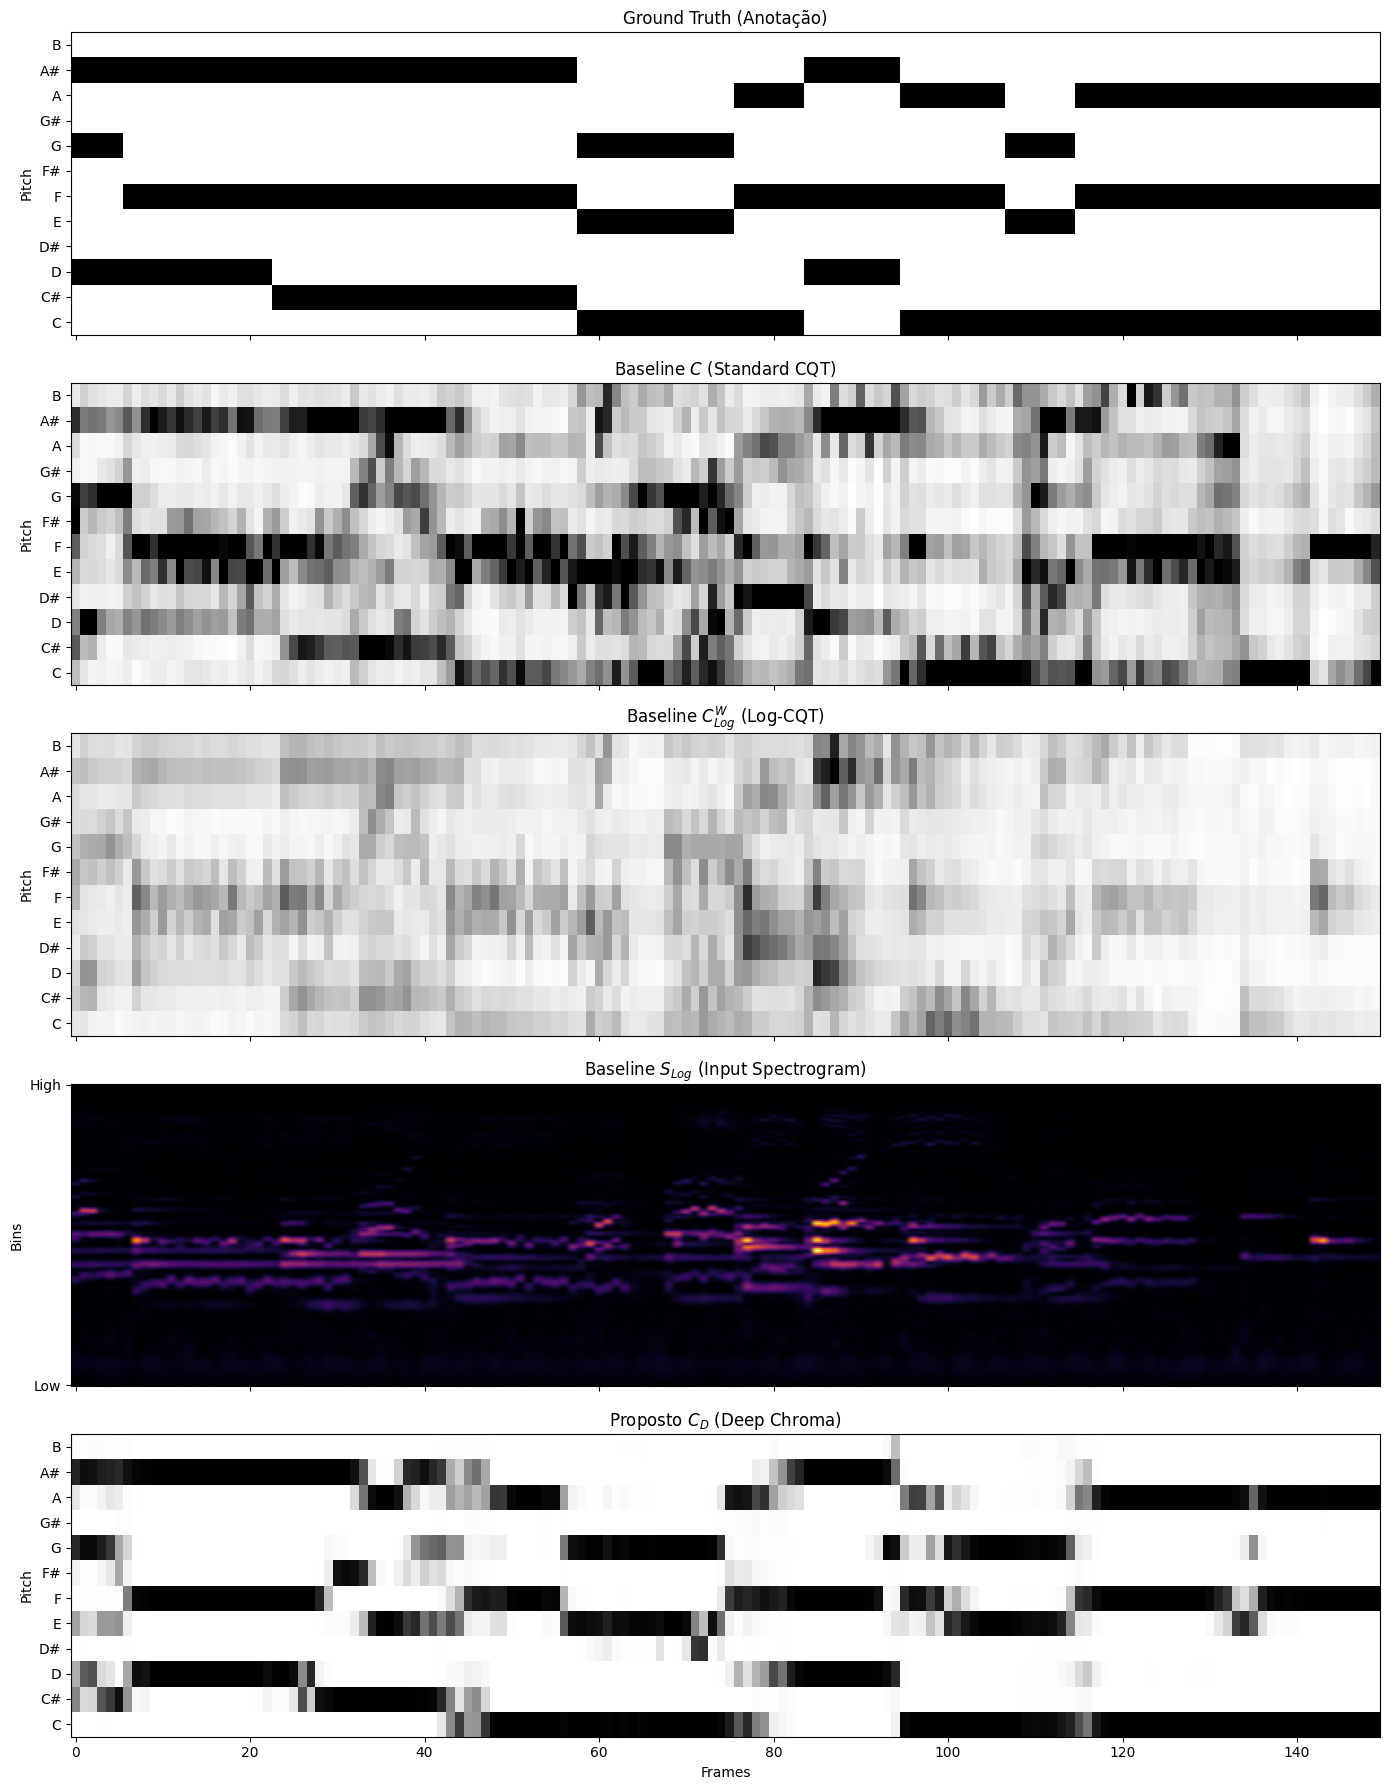

In [38]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_full_comparison(results_data, start_frame=500, duration_frames=200):
    """
    Plota a comparação visual, reconstruindo a visualização de tríades para o Ground Truth.
    """
    end_frame = start_frame + duration_frames

    # Recorte dos dados
    # Transpomos (.T) porque o imshow espera (Frequência, Tempo)
    gt_slice = y_true[start_frame:end_frame].T

    # 2. Preparar as outras features (Transposição normal)
    c_slice = results_data['C'][start_frame:end_frame].T
    c_log_slice = results_data['C_log'][start_frame:end_frame].T
    s_log_slice = results_data['S_log'][start_frame:end_frame].T 
    deep_slice = results_data['Deep'][start_frame:end_frame].T

    # 3. Plotagem
    fig, ax = plt.subplots(5, 1, figsize=(14, 18), sharex=True)
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Plot 1: Ground Truth Reconstruído
    ax[0].imshow(gt_slice, aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=1)
    ax[0].set_title("Ground Truth (Anotação)")
    ax[0].set_ylabel("Pitch")
    ax[0].set_yticks(range(12))
    ax[0].set_yticklabels(notes)
    
    # Plot 2: Baseline C
    ax[1].imshow(c_slice, aspect='auto', cmap='gray_r', origin='lower')
    ax[1].set_title(r"Baseline $C$ (Standard CQT)")
    ax[1].set_ylabel("Pitch")
    ax[1].set_yticks(range(12))
    ax[1].set_yticklabels(notes)

    # Plot 3: Baseline C_log
    ax[2].imshow(c_log_slice, aspect='auto', cmap='gray_r', origin='lower')
    ax[2].set_title(r"Baseline $C_{Log}^W$ (Log-CQT)")
    ax[2].set_ylabel("Pitch")
    ax[2].set_yticks(range(12))
    ax[2].set_yticklabels(notes)

    # Plot 4: Espectrograma
    ax[3].imshow(s_log_slice, aspect='auto', cmap='inferno', origin='lower')
    ax[3].set_title(r"Baseline $S_{Log}$ (Input Spectrogram)")
    ax[3].set_ylabel("Bins")
    ax[3].set_yticks([0, 177])
    ax[3].set_yticklabels(['Low', 'High'])

    # Plot 5: Deep Chroma
    ax[4].imshow(deep_slice, aspect='auto', cmap='gray_r', origin='lower', vmin=0, vmax=1)
    ax[4].set_title(r"Proposto $C_D$ (Deep Chroma)")
    ax[4].set_xlabel("Frames")
    ax[4].set_ylabel("Pitch")
    ax[4].set_yticks(range(12))
    ax[4].set_yticklabels(notes)
    
    plt.tight_layout()
    plt.show()

# --- COMO RODAR ---
if 'results_data' in locals():
    plot_full_comparison(results_data, start_frame=500, duration_frames=150)
else:
    print("Variável 'results_data' não encontrada. Rode a extração completa antes.")

**Saliency Map**

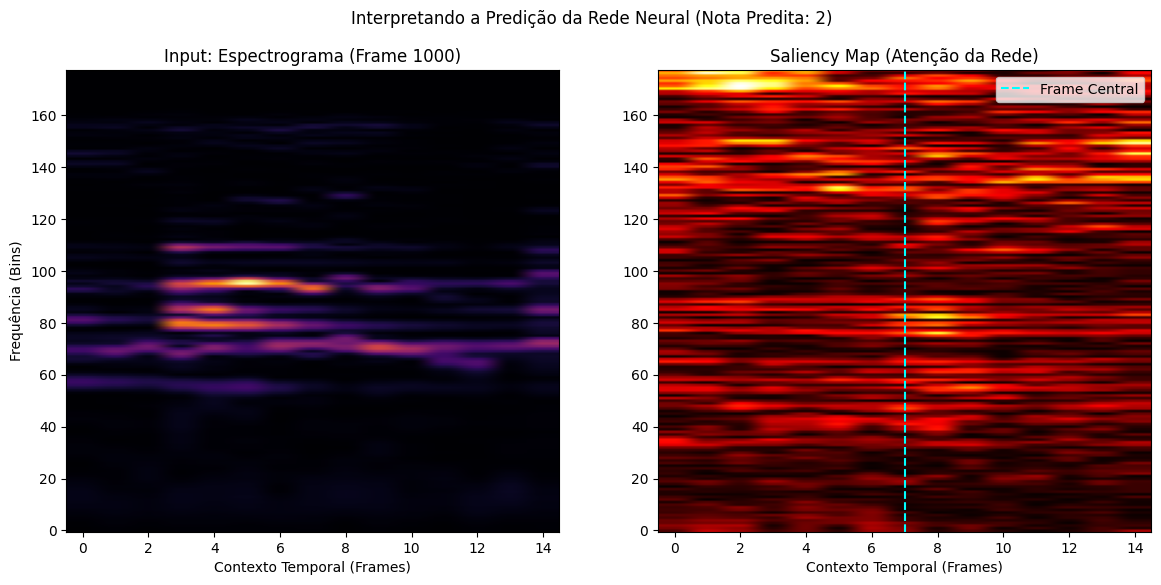

In [35]:
import tensorflow as tf

def plot_saliency_map(model, audio_path, target_frame_idx=None):
    """
    Gera um Mapa de Saliência para um frame específico.
    Mostra quais pixels do espectrograma ativaram a rede.
    """
    # 1. Preparar o Input (Espectrograma)
    spec = compute_log_spectrogram(audio_path)
    spec_padded = np.pad(spec, ((CONTEXT_W, CONTEXT_W), (0, 0)), mode='constant')
    
    # Se não definirmos um frame, pegamos um no meio
    if target_frame_idx is None:
        target_frame_idx = spec.shape[0] // 2
        
    # Recorta a janela (Super-frame) que a rede vai ver
    # Input shape deve ser (1, 2670)
    input_window = spec_padded[target_frame_idx : target_frame_idx + (2*CONTEXT_W + 1)].flatten()
    input_tensor = tf.convert_to_tensor(input_window.reshape(1, -1), dtype=tf.float32)
    
    # 2. Calcular Gradientes (Saliency)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        # Passa pela rede
        prediction = model(input_tensor)
        # Queremos explicar a nota mais forte (a predita)
        top_class_idx = tf.argmax(prediction[0])
        loss = prediction[0, top_class_idx]
        
    # Pega o gradiente da SAÍDA em relação à ENTRADA
    grads = tape.gradient(loss, input_tensor)
    
    # Processa o gradiente para visualização (magnitude)
    saliency = tf.abs(grads).numpy().reshape(15, 178) # Volta para (Tempo, Freq)
    original_spec = input_window.reshape(15, 178)
    
    # 3. Plotar
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Espectrograma Original
    ax[0].imshow(original_spec.T, aspect='auto', origin='lower', cmap='inferno')
    ax[0].set_title(f"Input: Espectrograma (Frame {target_frame_idx})")
    ax[0].set_ylabel("Frequência (Bins)")
    ax[0].set_xlabel("Contexto Temporal (Frames)")
    
    # Mapa de Saliência (O que foi importante)
    # Cores quentes = Alta importância
    ax[1].imshow(saliency.T, aspect='auto', origin='lower', cmap='hot')
    ax[1].set_title(f"Saliency Map (Atenção da Rede)")
    ax[1].set_xlabel("Contexto Temporal (Frames)")
    
    # Desenha uma linha no centro (frame atual)
    ax[1].axvline(x=7, color='cyan', linestyle='--', label='Frame Central')
    ax[1].legend()

    plt.suptitle(f"Interpretando a Predição da Rede Neural (Nota Predita: {top_class_idx})")
    plt.show()

# --- COMO RODAR ---
# Escolha um arquivo de teste e um frame
test_file = test_files[0] # Pega a primeira música de teste
audio_path_ex = os.path.join(AUDIO_DIR, test_file + '.wav')

try:
    plot_saliency_map(model, audio_path_ex, target_frame_idx=1000)
except Exception as e:
    print(f"Erro ao gerar saliência (verifique se o caminho do áudio está certo): {e}")

**Descobrindo a janela ideal**

--- INICIANDO BUSCA PELA JANELA IDEAL (GRID SEARCH) ---

Testando Contexto: +/- 3 frames (Janela total: 7 frames)...
Carregando 18 arquivos...
Carregando 2 arquivos...
-> Melhor Acurácia na Validação: 34.73%

Testando Contexto: +/- 7 frames (Janela total: 15 frames)...
Carregando 18 arquivos...
Carregando 2 arquivos...
-> Melhor Acurácia na Validação: 33.85%

Testando Contexto: +/- 14 frames (Janela total: 29 frames)...
Carregando 18 arquivos...
Carregando 2 arquivos...
-> Melhor Acurácia na Validação: 39.75%

VENCEDOR: Contexto +/- 14 frames
Isso equivale a uma janela de 2.90 segundos


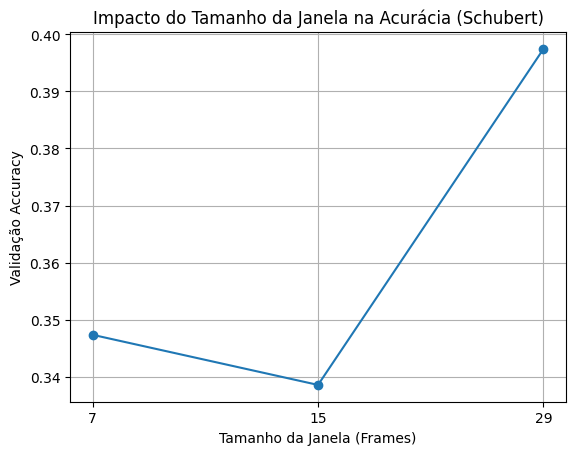

In [37]:
import matplotlib.pyplot as plt

# 1. Definir os candidatos a teste
# Contexto de 3 frames para cada lado = ~0.7s total
# Contexto de 7 frames para cada lado = ~1.5s total (Original do Artigo)
# Contexto de 14 frames para cada lado = ~2.9s total
candidates = [3, 7, 14] 
results = {}

print("--- INICIANDO BUSCA PELA JANELA IDEAL (GRID SEARCH) ---")

for w in candidates:
    print(f"\nTestando Contexto: +/- {w} frames (Janela total: {2*w+1} frames)...")
    
    # A. Atualizar o Gerador com o novo Contexto
    # Precisamos recriar o gerador pois o padding muda
    global CONTEXT_W
    CONTEXT_W = w 
    
    train_gen_test = SchubertDataGenerator(train_files, AUDIO_DIR, ANNOT_DIR, batch_size=512)
    val_gen_test = SchubertDataGenerator(val_files, AUDIO_DIR, ANNOT_DIR, batch_size=512, shuffle=False)
    
    # B. Recriar o Modelo (O input shape muda!)
    input_dim = (2 * w + 1) * 178
    
    model_test = Sequential([
        Input(shape=(input_dim,)), 
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='sigmoid')
    ])
    
    model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # C. Treino Rápido (Early Stopping agressivo)
    # Não precisamos de 50 épocas para saber se é ruim. 10 bastam.
    history = model_test.fit(
        train_gen_test,
        validation_data=val_gen_test,
        epochs=10, 
        verbose=0 # Silencioso para não poluir
    )
    
    # Pegar a melhor acurácia de validação alcançada
    best_val_acc = max(history.history['val_accuracy'])
    results[w] = best_val_acc
    print(f"-> Melhor Acurácia na Validação: {best_val_acc:.2%}")

# 3. Mostrar o Vencedor
best_w = max(results, key=results.get)
print("\n" + "="*40)
print(f"VENCEDOR: Contexto +/- {best_w} frames")
print(f"Isso equivale a uma janela de {((2*best_w+1)*HOP_SIZE)/SR:.2f} segundos")
print("="*40)

# Plotar gráfico similar à Figura 2 do artigo
plt.plot([str(2*c+1) for c in candidates], list(results.values()), marker='o')
plt.title("Impacto do Tamanho da Janela na Acurácia (Schubert)")
plt.xlabel("Tamanho da Janela (Frames)")
plt.ylabel("Validação Accuracy")
plt.grid(True)
plt.show()

**Salvando modelo**

In [41]:
# No notebook de Treino:
model.save('schubert_deep_chroma.keras')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!
